<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%206%20-%20Batch%20Normalization%20and%20Regularization/Eva5_session_6_BN_L1_L2_Regularization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Session 6 
study the Impact of differnt regularization technique 
1. Batch Normalization
2. BN + L1
3. BN + L2
4. BN + L1 L2

# Import Libraries

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

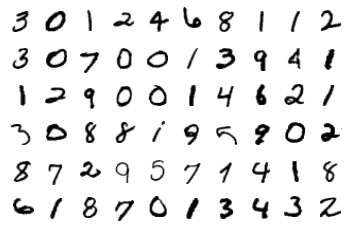

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [13]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 28  RF : 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            #GhostBatchNorm(num_features =24, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 26   RF : 5

          # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU() 
        )  # output_size = 26  RF 5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 13  RF 6

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #GhostBatchNorm(num_features =10, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 13   RF : 10

        self.convblock41 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) #output_size = 11  RF : 14
       
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 9  RF :18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #GhostBatchNorm(num_features =16, num_splits=2),
            nn.Dropout(dropout_value)
        ) # output_size = 7 RF 22

        
        self.gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size =(7,7))
        ) # output_size = 1  RF 34
        #  # Output BLOCK 
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          
        ) # output_size = 1  RF 34
       

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock41(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap1(x)
        x = self.convblock7(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 24, 26, 26]           2,160
              ReLU-6           [-1, 24, 26, 26]               0
       BatchNorm2d-7           [-1, 24, 26, 26]              48
           Dropout-8           [-1, 24, 26, 26]               0
            Conv2d-9           [-1, 10, 26, 26]             240
             ReLU-10           [-1, 10, 26, 26]               0
        MaxPool2d-11           [-1, 10, 13, 13]               0
           Conv2d-12           [-1, 10, 13, 13]             900
             ReLU-13           [-1, 10, 13, 13]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [15]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,l1_factor, train_losses, train_acc ):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    #implement L1 Loss if l1_factor >0
    if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,test_losses,test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Function to get the Misclassfied Images & Plot it

In [16]:
def getmissclassifiedImage(model, device, test_loader):
  misclassified = []
  misclassified_pred = []
  misclassified_target = []
  misclassfiled_list = []
  model.eval()

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
     
      output = model(data)
      pred = output.argmax(dim =1, keepdim =True)
      
      list_misclassified = (pred.eq(target.view_as(pred)) == False)
      batch_misclassified = data[list_misclassified]
      batch_mis_pred = pred[list_misclassified]
      batch_mis_target = target.view_as(pred)[list_misclassified]

      misclassified.append(batch_misclassified)
      misclassified_pred.append(batch_mis_pred)
      misclassified_target.append(batch_mis_target)
                                  
  # group all the batched together
  
  misclassified = torch.cat(misclassified)
  misclassified_pred = torch.cat(misclassified_pred)
  misclassified_target = torch.cat(misclassified_target)  
                                
 
  misclassfiled_list.append(misclassified)
  misclassfiled_list.append(misclassified_pred)
  misclassfiled_list.append(misclassified_pred)

  return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))



In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
def Plot_misclassifed(model, device, test_loader):
 plt.style.use("dark_background")
 misclassified = getmissclassifiedImage(model, device, test_loader)
 num_images = 25
 fig = plt.figure(figsize=(12, 12))
 for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
     image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
     ax = fig.add_subplot(5, 5, idx+1)
     ax.axis('off')
     ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
     ax.imshow(image.squeeze())
 plt.show()

# Let's Train and test our model

In [25]:

def runmodel(l1_factor,l2_factor,train_losses,train_acc,test_losses,test_acc):
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=l2_factor)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)    
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,l1_factor,train_losses,train_acc)
      scheduler.step()
      test(model, device, test_loader,test_losses,test_acc)
  Plot_misclassifed(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING BN ONLY
EPOCH: 0


Loss=0.1878853291273117 Batch_id=468 Accuracy=83.84: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1128, Accuracy: 9720/10000 (97.20%)

EPOCH: 1


Loss=0.0548204742372036 Batch_id=468 Accuracy=96.47: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.018406495451927185 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.06362012773752213 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:24<00:00, 18.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9845/10000 (98.45%)

EPOCH: 4


Loss=0.06017830967903137 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.02462156116962433 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:24<00:00, 19.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.10749957710504532 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:25<00:00, 18.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.06976975500583649 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.010146033950150013 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.023928506299853325 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.023357419297099113 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.09113659709692001 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.013021647930145264 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.0658356174826622 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:22<00:00, 20.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.01816771738231182 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.01719812862575054 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:22<00:00, 20.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.10691101104021072 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 20.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


Loss=0.1339503973722458 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:22<00:00, 20.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.06306030601263046 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 20.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 19


Loss=0.04938101768493652 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 20


Loss=0.041317474097013474 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.015433927066624165 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 22


Loss=0.013700195588171482 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 23


Loss=0.03917986527085304 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

EPOCH: 24


Loss=0.009414131753146648 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0246, Accuracy: 9925/10000 (99.25%)



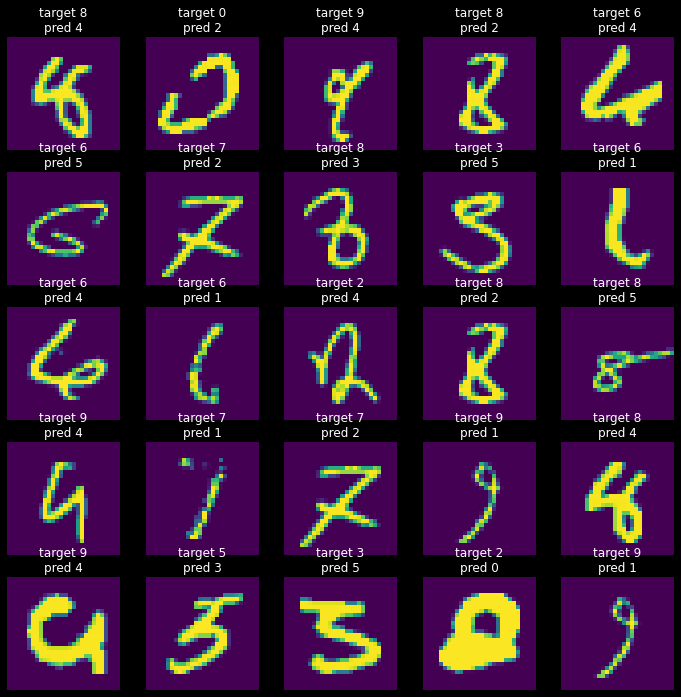

In [27]:
# BN only 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING BN ONLY")
l1_factor =0
l2_factor =0
train_losses_BN = []
test_losses_BN = []
train_acc_BN = []
test_acc_BN = []
runmodel(l1_factor,l2_factor,train_losses_BN,train_acc_BN,test_losses_BN,test_acc_BN)


  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING BN + L1 ONLY
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.15438389778137207 Batch_id=468 Accuracy=81.25: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9766/10000 (97.66%)

EPOCH: 1


Loss=0.13014636933803558 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0630, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.20063403248786926 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.21254807710647583 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.13143019378185272 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9880/10000 (98.80%)

EPOCH: 5


Loss=0.07706780731678009 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.08643991500139236 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.23986466228961945 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:27<00:00, 17.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.09192004799842834 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.09916906803846359 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


Loss=0.09517831355333328 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.08849943429231644 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.22983036935329437 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.06920740008354187 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.09048671275377274 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.11146900802850723 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.15724287927150726 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 17


Loss=0.10594503581523895 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.19281966984272003 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:26<00:00, 17.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.06676318496465683 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:26<00:00, 17.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.12759554386138916 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.07787782698869705 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


Loss=0.15994030237197876 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.1339815855026245 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 24


Loss=0.14390985667705536 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.06it/s]



Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)



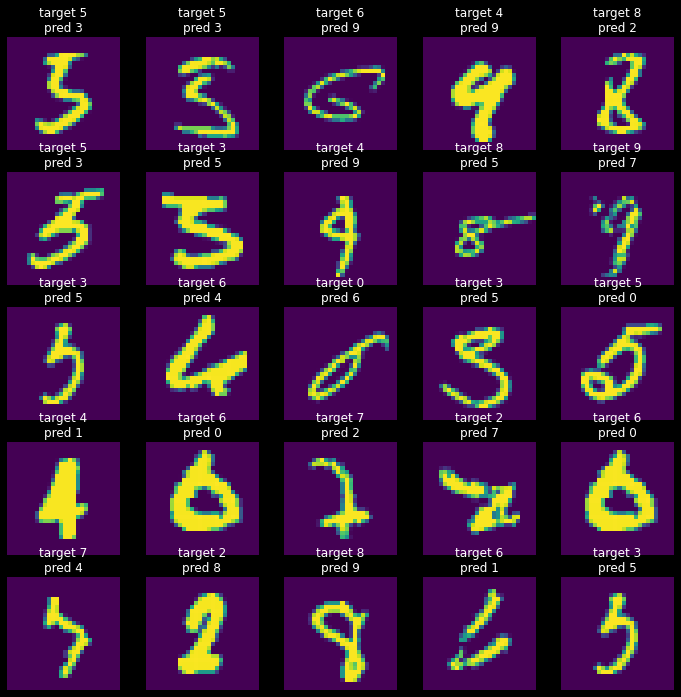

In [28]:
# BN + L1 
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING BN + L1 ONLY")
l1_factor =0.0001
l2_factor =0
train_losses_BN_L1 = []
test_losses_BN_L1 = []
train_acc_BN_L1 = []
test_acc_BN_L1 = [] 
runmodel(l1_factor,l2_factor,train_losses_BN_L1,train_acc_BN_L1,test_losses_BN_L1,test_acc_BN_L1)  
 

  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING BN + L2 ONLY
EPOCH: 0


Loss=0.21919725835323334 Batch_id=468 Accuracy=82.06: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1012, Accuracy: 9728/10000 (97.28%)

EPOCH: 1


Loss=0.04248690977692604 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9841/10000 (98.41%)

EPOCH: 2


Loss=0.12026163935661316 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.0421328991651535 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9881/10000 (98.81%)

EPOCH: 4


Loss=0.04087161645293236 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.09775125235319138 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:22<00:00, 20.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.02385953813791275 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.08602627366781235 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.04956789314746857 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 20.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.028139352798461914 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.02846825309097767 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.14537568390369415 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.015661338344216347 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:23<00:00, 19.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.050725217908620834 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:24<00:00, 19.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.013213046826422215 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.023153869435191154 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


Loss=0.06437522172927856 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.06424761563539505 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.06654542684555054 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:24<00:00, 19.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 19


Loss=0.01939602568745613 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.004954667296260595 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:24<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.02854866348206997 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:23<00:00, 19.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.042765166610479355 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


Loss=0.03443514183163643 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 24


Loss=0.012204491533339024 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)



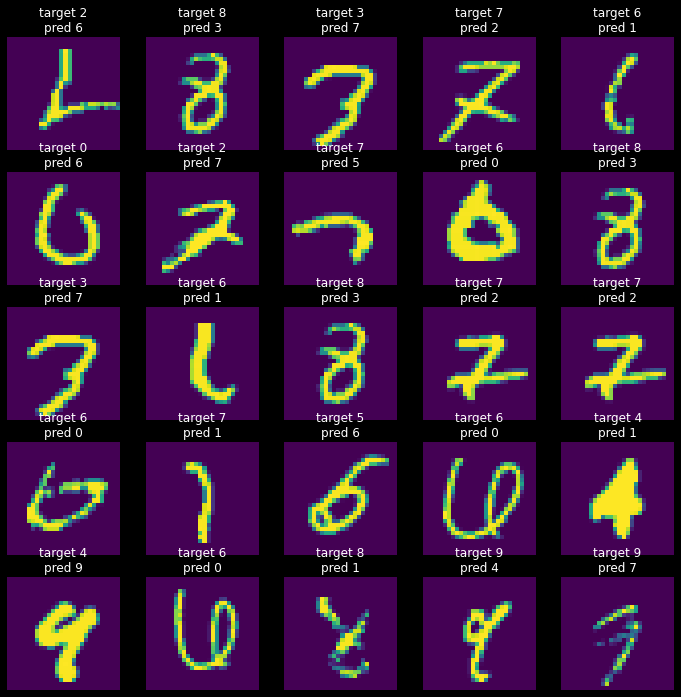

In [29]:
# BN + L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25

print("PROCESSING BN + L2 ONLY")
l1_factor =0
l2_factor =0.0001
train_losses_BN_L2 = []
test_losses_BN_L2 = []
train_acc_BN_L2 = []
test_acc_BN_L2 = []
runmodel(l1_factor,l2_factor,train_losses_BN_L2,train_acc_BN_L2,test_losses_BN_L2,test_acc_BN_L2)


  0%|          | 0/469 [00:00<?, ?it/s]

PROCESSING BN + L1 & L2 
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.23605506122112274 Batch_id=468 Accuracy=84.04: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1253, Accuracy: 9667/10000 (96.67%)

EPOCH: 1


Loss=0.11876910924911499 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.1634792536497116 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9873/10000 (98.73%)

EPOCH: 3


Loss=0.11067213118076324 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.1712331771850586 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9869/10000 (98.69%)

EPOCH: 5


Loss=0.14236463606357574 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.12351691722869873 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:27<00:00, 17.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.1937486231327057 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


Loss=0.12850329279899597 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:27<00:00, 17.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.13454927504062653 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.10383044183254242 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9947/10000 (99.47%)

EPOCH: 11


Loss=0.0807303637266159 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.11366085708141327 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.08217263221740723 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.0945809930562973 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.0880998820066452 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:27<00:00, 17.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9942/10000 (99.42%)

EPOCH: 16


Loss=0.09800359606742859 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:27<00:00, 17.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9950/10000 (99.50%)

EPOCH: 17


Loss=0.10955008864402771 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:27<00:00, 17.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9949/10000 (99.49%)

EPOCH: 18


Loss=0.08428286761045456 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9951/10000 (99.51%)

EPOCH: 19


Loss=0.06995131820440292 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9947/10000 (99.47%)

EPOCH: 20


Loss=0.09293195605278015 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9949/10000 (99.49%)

EPOCH: 21


Loss=0.0876920074224472 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9949/10000 (99.49%)

EPOCH: 22


Loss=0.12103362381458282 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.12321264296770096 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:27<00:00, 17.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9947/10000 (99.47%)

EPOCH: 24


Loss=0.09840930998325348 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:27<00:00, 17.04it/s]



Test set: Average loss: 0.0216, Accuracy: 9949/10000 (99.49%)



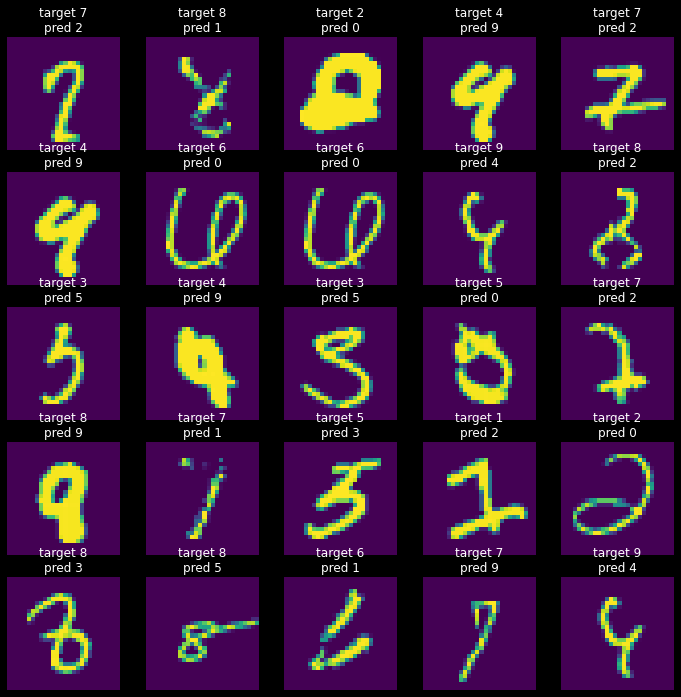

In [30]:
# BN + L1 L2
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)

EPOCHS = 25
print("PROCESSING BN + L1 & L2 ")
l1_factor =0.0001
l2_factor =0.0001
train_losses_BN_L12 = []
test_losses_BN_L12 = []
train_acc_BN_L12 = []
test_acc_BN_L12 = []
runmodel(l1_factor,l2_factor,train_losses_BN_L12,train_acc_BN_L12,test_losses_BN_L12,test_acc_BN_L12)

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric(BN, l1, l2, l1_l2, metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    BN_plt, = plt.plot(BN)
    l1_plt, = plt.plot(l1)
    l2_plt, = plt.plot(l2)
    l1_l2_plt, = plt.plot(l1_l2)

    # Set plot title
    plt.title(f'{metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (BN_plt, l1_plt, l2_plt, l1_l2_plt),
        ('BN', 'L1', 'L2', 'L1 + L2'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )

    # Save plot
    fig.savefig(f'{metric.lower()}_change.png')

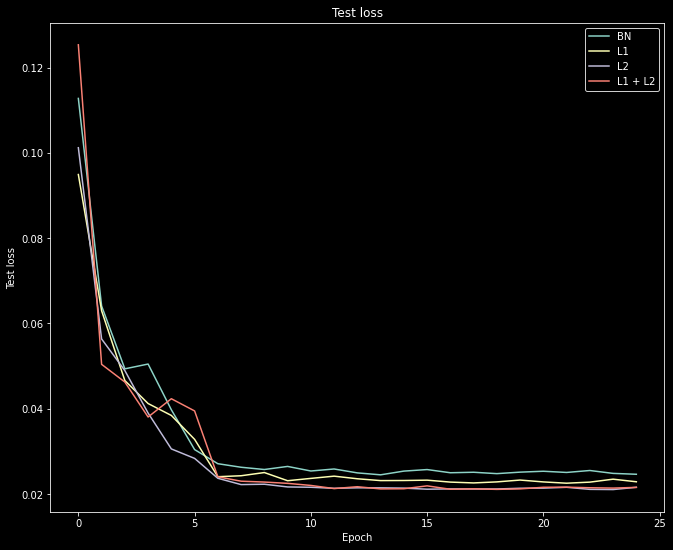

In [32]:
plot_metric(test_losses_BN, test_losses_BN_L1, test_losses_BN_L2, test_losses_BN_L12, 'Test loss')


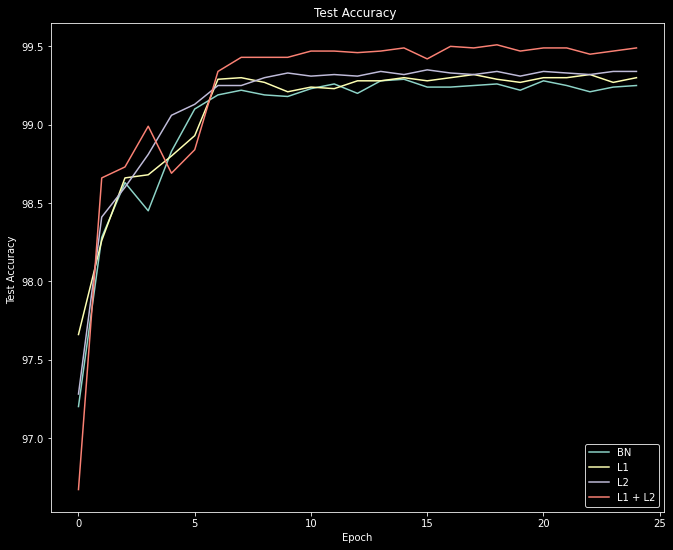

In [33]:
plot_metric(test_acc_BN, test_acc_BN_L1, test_acc_BN_L2, test_acc_BN_L12, 'Test Accuracy ')


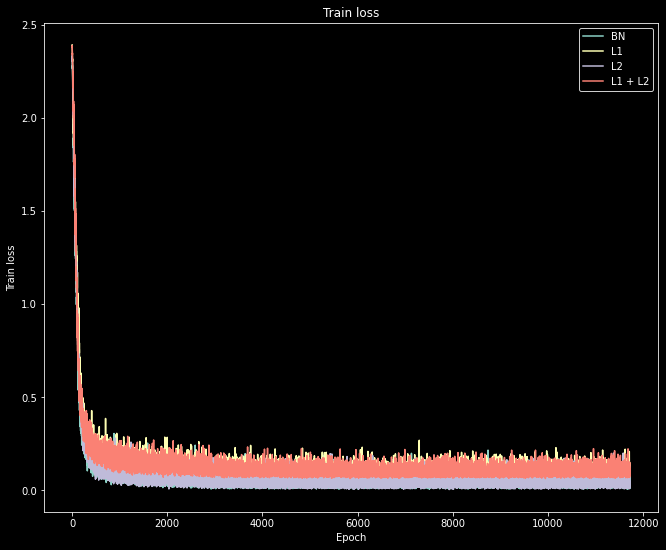

In [34]:
plot_metric(train_losses_BN, train_losses_BN_L1, train_losses_BN_L2, train_losses_BN_L12, 'Train loss')


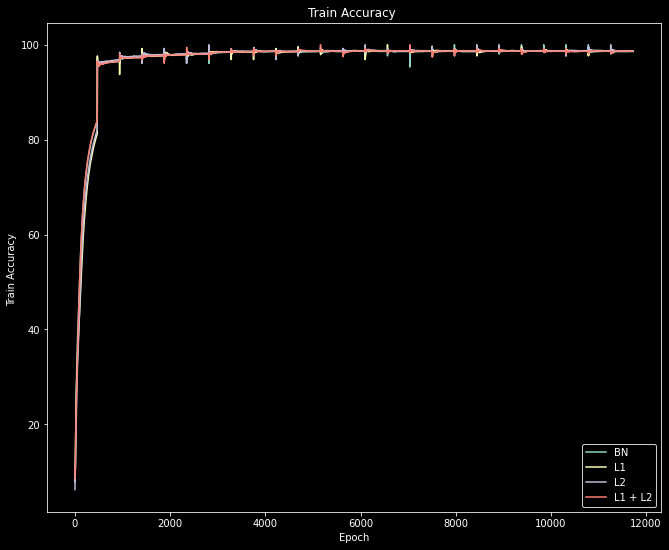

In [35]:
plot_metric(train_acc_BN, train_acc_BN_L1, train_acc_BN_L2, train_acc_BN_L12, 'Train Accuracy ')